In [88]:
#%% importing packages
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns

# Import all models
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import sklearn.metrics as metrics

In [89]:
#%%import data sets
X_train = pd.read_csv("C:\\Users\\jenny\\Desktop\\springboard\\capstone1\\feature\\scaled_X_train.csv").iloc[:,1:]
y_train = pd.read_csv("C:\\Users\\jenny\\Desktop\\springboard\\capstone1\\feature\\y_train.csv").iloc[:,1:]
X_test = pd.read_csv("C:\\Users\\jenny\\Desktop\\springboard\\capstone1\\feature\\scaled_X_test.csv").iloc[:,1:]
y_test = pd.read_csv("C:\\Users\\jenny\\Desktop\\springboard\\capstone1\\feature\\y_test.csv").iloc[:,1:]

x = X_train.drop(['weapon','user','ranking'],axis=1)
x_test = X_test.drop(['weapon','user','ranking'],axis=1)

In [90]:
#%% KMeans Classification
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsRegressor()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(x, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [91]:
print("The best R-squared score: "+str(knn_cv.best_score_))
#this is really poor,

The best R-squared score: 0.10551776727241642


In [92]:
#%% Outlier Detection
# fit the model for outlier detection make a grid search for parameters
holder = pd.DataFrame({'lof' : [0]*990})
for nn in range(10,1000):
    clf = LocalOutlierFactor(n_neighbors=nn, contamination=0.1)
    y_pred = clf.fit_predict(x,y_train)
    holder.iloc[(nn-10),0] = np.max(abs(clf.negative_outlier_factor_))

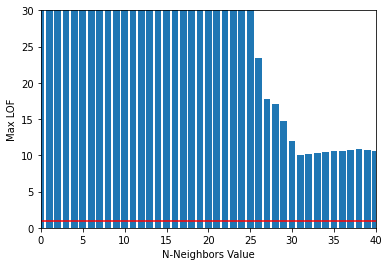

<Figure size 432x288 with 0 Axes>

In [93]:
#%% Plotting the LOF across all the nearest neighbors
hindex = pd.DataFrame({'i':holder.index})
plt.ylim([0,30])
plt.xlim(0,40)
plt.bar(x=hindex.loc[:,'i'],height=holder.loc[:,'lof'])
plt.xlabel("N-Neighbors Value")
plt.ylabel("Max LOF")
plt.axhline(y=1, color='r', linestyle='-')
plt.show()
plt.savefig('max_lof_plt.png')

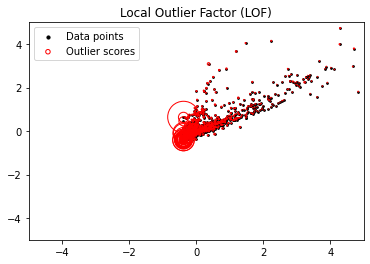

In [94]:
#%%looks like 31 neighbors is the best solution
clf_final = LocalOutlierFactor(n_neighbors=31, contamination=0.1)
y_pred = clf_final.fit_predict(x,y_train)
lof = abs(clf_final.negative_outlier_factor_)
X_scores = clf_final.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(x.iloc[:, 0], x.iloc[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(x.iloc[:, 0], x.iloc[:, 1], s=1000 * radius, edgecolors='r', facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [95]:
#%%making it into a category variable for the Kmeans
cat_lof = np.zeros((x.shape[0],1))
for i in range(0,x.shape[0]):
    if lof[i] > 1.5:
        cat_lof[i,0]=1
param_grid = {'n_neighbors':np.arange(1,10)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(x, np.ravel(cat_lof))
#getting the best based on the grid search
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.9608058608058607
Best Parameters: {'n_neighbors': 1}


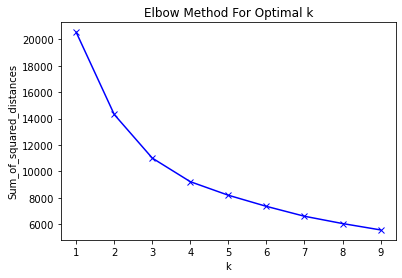

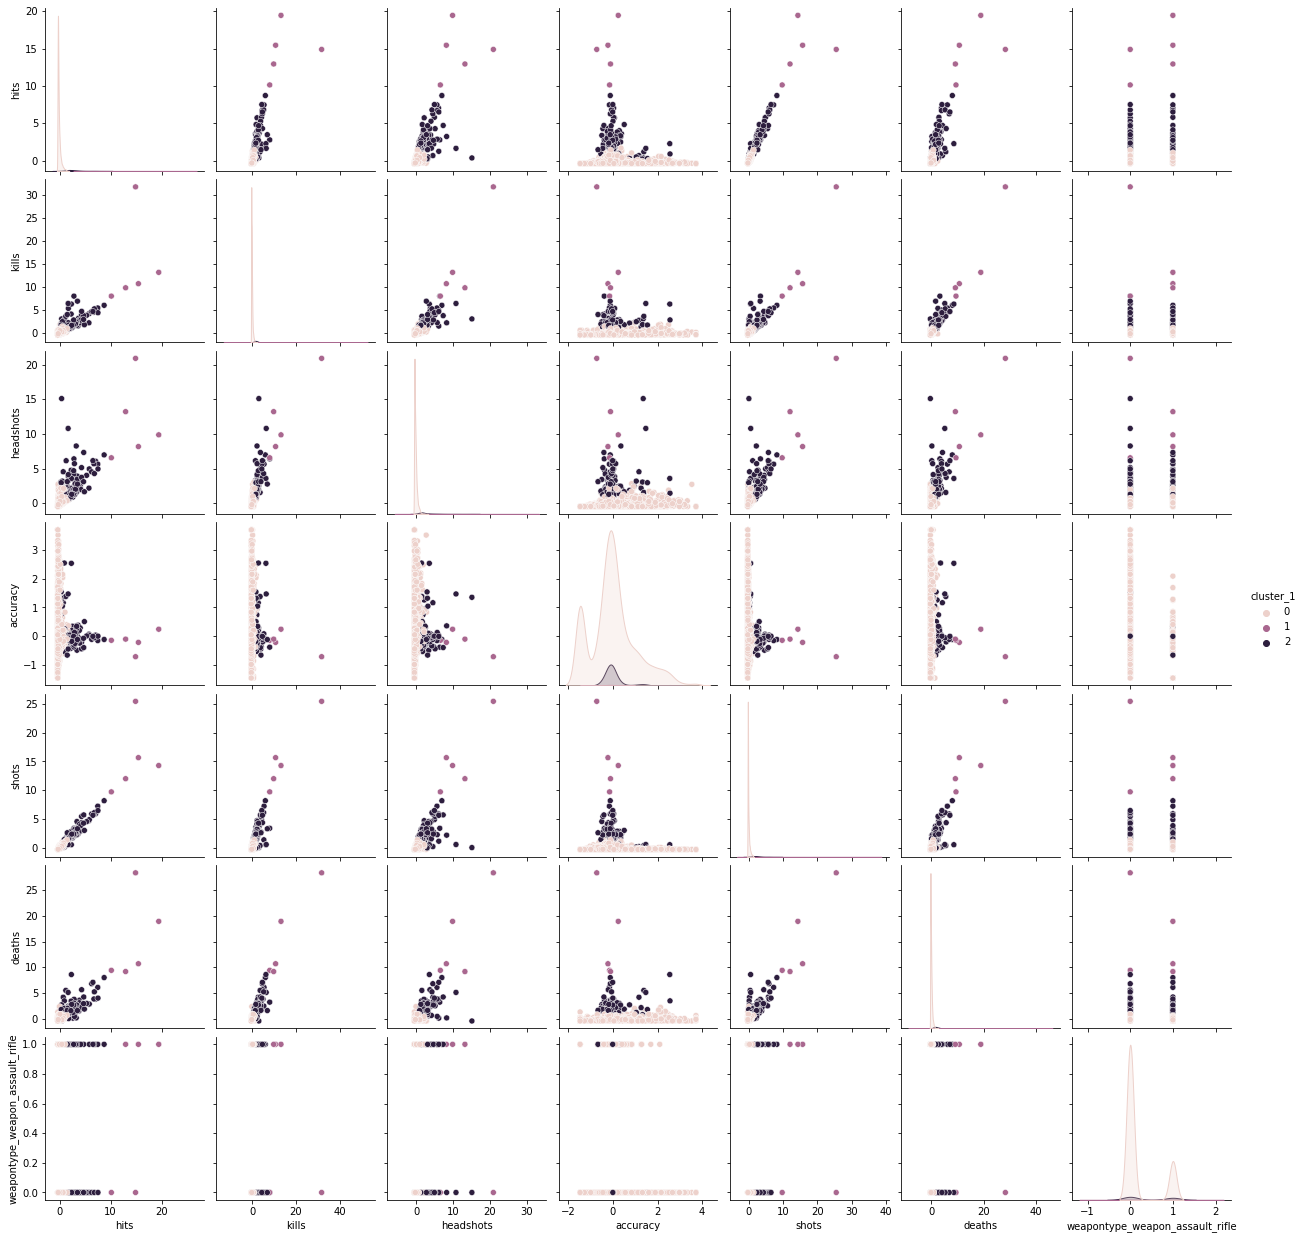

In [96]:
#%% doing kmeans to get the elbow plot
Sum_of_squared_distances = []
from sklearn.cluster import KMeans
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(x,np.ravel(cat_lof))
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
#based on this I will go with two clusters here a plot of the clusters
km = KMeans(n_clusters=3)
distances_1 = km.fit_transform(x,np.ravel(cat_lof))
labels_1 = km.labels_
x['cluster_1']=labels_1
with sns.color_palette("hls", 8):
    sns.pairplot(x.iloc[:,[0,1,2,3,4,5,6,19]], hue='cluster_1')

In [97]:
#do the bagging after the grid search with the classification being the outliers in the training data set. Then make predictions with the testing data set
x_no_cluster = x.drop(['cluster_1'],axis=1)
clf = BaggingClassifier(base_estimator=KMeans(n_clusters=2), n_estimators=20, random_state=0).fit(x_no_cluster,np.ravel(cat_lof))

#implementing the same classification to the test data set
x = X_train.drop(['weapon','user','ranking'],axis=1)
x_test = X_test.drop(['weapon','user','ranking'],axis=1)
clf_final = LocalOutlierFactor(n_neighbors=31, contamination=0.1,novelty=True).fit(x,y_train)
y_pred_test = clf_final.predict(x_test)
lof = abs(clf_final.negative_outlier_factor_)
test_lof = np.zeros((x_test.shape[0],1))
for i in range(0,x_test.shape[0]):
    if lof[i] > 1.5:
        test_lof[i,0]=1

y_pred_test = clf.predict(x_test)

#looking at the results of the test set
print("Bagging Classifier test")
print("Accuracy:", metrics.accuracy_score(test_lof,y_pred_test))
print("Balanced accuracy:", metrics.balanced_accuracy_score(test_lof,y_pred_test))
print('Precision score for not outlier' , metrics.precision_score(test_lof,y_pred_test, pos_label = 0))
print('Precision score for outlier' , metrics.precision_score(test_lof,y_pred_test, pos_label = 1))
print('Recall score for not outlier' , metrics.recall_score(test_lof,y_pred_test, pos_label = 0))
print('Recall score for outlier' , metrics.recall_score(test_lof,y_pred_test, pos_label = 1))

Bagging Classifier test
Accuracy: 0.7837541163556532
Balanced accuracy: 0.4965229485396384
Precision score for not outlier 0.7880794701986755
Precision score for outlier 0.0
Recall score for not outlier 0.9930458970792768
Recall score for outlier 0.0


In [44]:
#the original KMeans results
y_pred_test = km.predict(x_test)

#looking at the results of the test set
print("KMeans Classifier test")
print("Accuracy:", metrics.accuracy_score(test_lof,y_pred_test))
print("Balanced accuracy:", metrics.balanced_accuracy_score(test_lof,y_pred_test))
print('Precision' , metrics.precision_score(test_lof,y_pred_test, pos_label = 0,average=None))
print('Recall' , metrics.recall_score(test_lof,y_pred_test, pos_label = 0,average=None))

KMeans Classifier test
Accuracy: 0.7574094401756312
Balanced accuracy: 0.47983310152990266
Precision [0.79401611 0.         0.        ]
Recall [0.9596662 0.        0.       ]


C:\Users\jenny\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jenny\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
C:\Users\jenny\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators':np.arange(1,200)}
rfc = RandomForestClassifier(random_state = 1,n_jobs=-1)
rfc_cv= GridSearchCV(rfc,param_grid,cv=5)
rfc_cv.fit(x, np.ravel(cat_lof))
#getting the best based on the grid search
print("Best Score:" + str(rfc_cv.best_score_))
print("Best Parameters: " + str(rfc_cv.best_params_))

Best Score:0.9461538461538461
Best Parameters: {'n_estimators': 155}


In [46]:
clf = RandomForestClassifier(n_estimators=155, random_state = 1,n_jobs=-1)
model_res = clf.fit(x,np.ravel(cat_lof))
y_pred_test = model_res.predict(x_test)
y_pred_prob = model_res.predict_proba(x_test)
lr_probs = y_pred_prob[:,1]

#looking at the results of the test set
print("Random Forest Classifer Results")
print("Accuracy:", metrics.accuracy_score(test_lof,y_pred_test))
print("Balanced accuracy:", metrics.balanced_accuracy_score(test_lof,y_pred_test))
print('Precision score for not outlier' , metrics.precision_score(test_lof,y_pred_test, pos_label = 0))
print('Precision score for outlier' , metrics.precision_score(test_lof,y_pred_test, pos_label = 1))
print('Recall score for not outlier' , metrics.recall_score(test_lof,y_pred_test, pos_label = 0))
print('Recall score for outlier' , metrics.recall_score(test_lof,y_pred_test, pos_label = 1))

Random Forest Classifer Results
Accuracy: 0.7003293084522503
Balanced accuracy: 0.49329943208159477
Precision score for not outlier 0.7866323907455013
Precision score for outlier 0.19548872180451127
Recall score for not outlier 0.8511821974965229
Recall score for outlier 0.13541666666666666


19


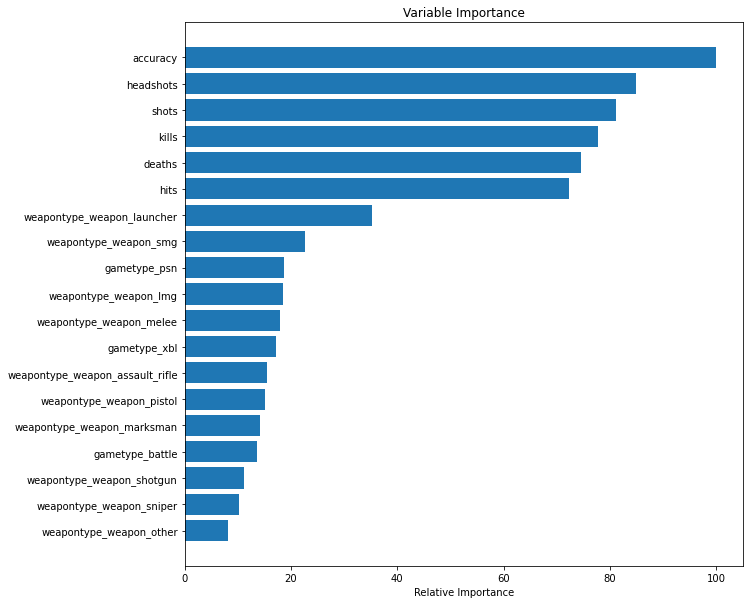

In [47]:
#importance of inputs for the random forest
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

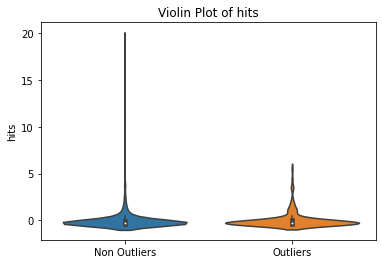

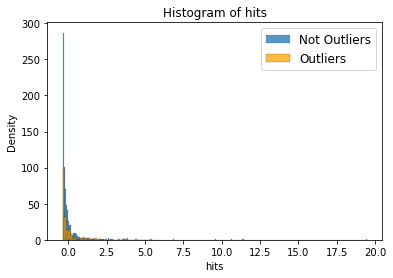

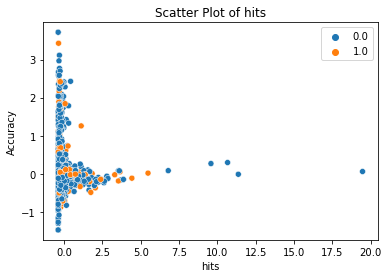

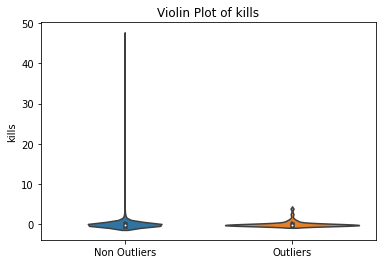

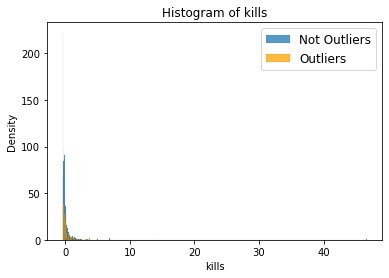

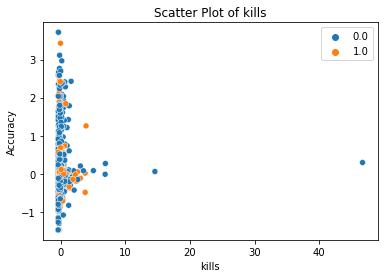

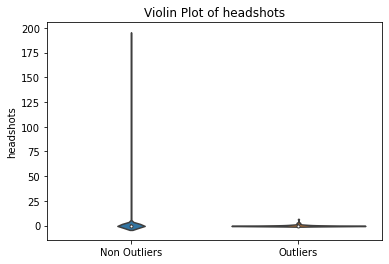

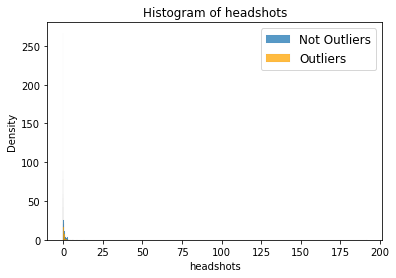

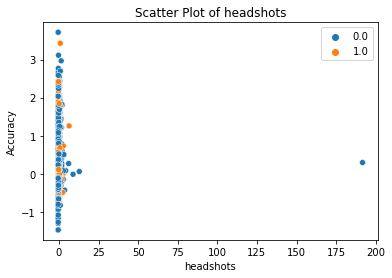

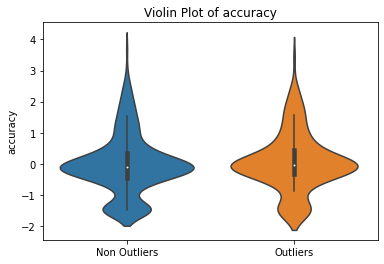

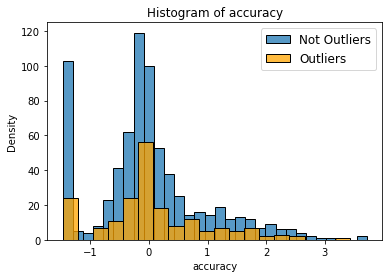

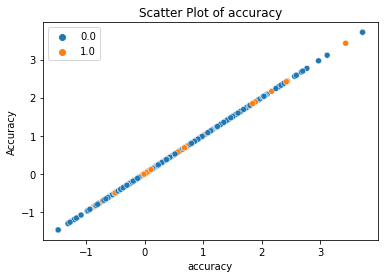

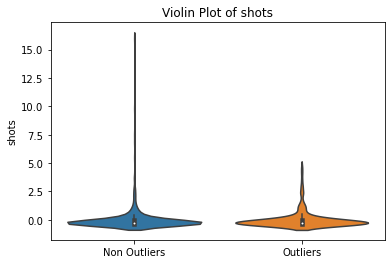

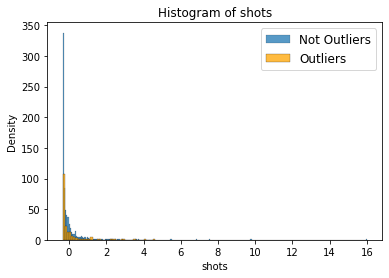

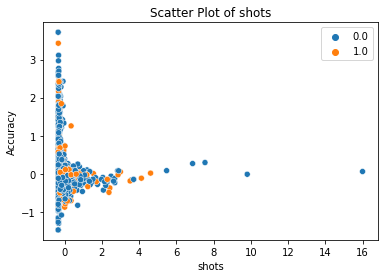

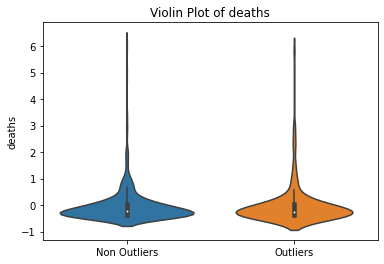

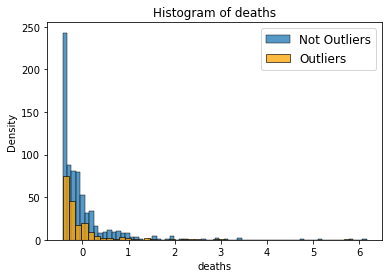

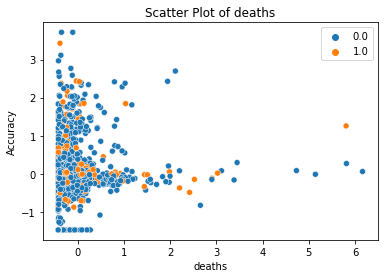

In [104]:
#it appears that the random forest model is the best. It could still be improved.
#Let's explore what the outliers look like with some basic plots.
#vilion plots
for i in range(0,6):
    sns.violinplot(x=test_lof[:,0],y=x_test.iloc[:,i],data=x_test)
    plt.title('Violin Plot of '+x_test.columns[i])
    plt.xticks(np.arange(2),('Non Outliers','Outliers'))
    plt.show()

#histograms
    df = x_test[test_lof[:,0]==0]
    sns.histplot(df.iloc[:,i],kde=False,label="Not Outliers")
    df = x_test[test_lof[:,0]==1]
    sns.histplot(df.iloc[:,i],kde=False,label="Outliers",color='orange')
    plt.legend(prop={'size': 12})
    plt.title('Histogram of '+x_test.columns[i])
    plt.xlabel(x_test.columns[i])
    plt.ylabel('Density')
    plt.show()

#scatter plot
    sns.scatterplot(data=x_test,x=x_test.iloc[:,i],y='accuracy',hue=test_lof[:,0])
    plt.xlabel(x_test.columns[i])
    plt.ylabel('Accuracy')
    plt.title("Scatter Plot of "+x_test.columns[i])
    plt.show()

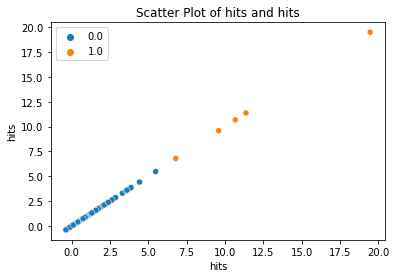

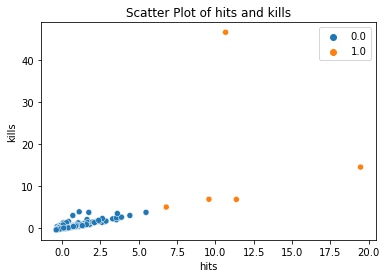

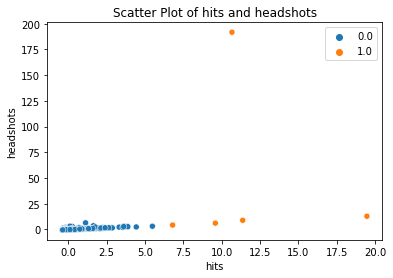

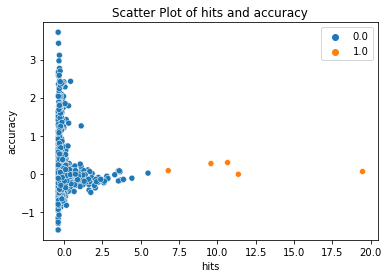

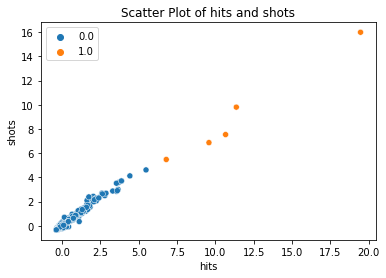

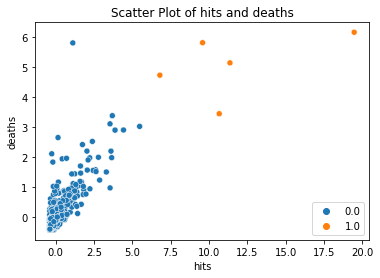

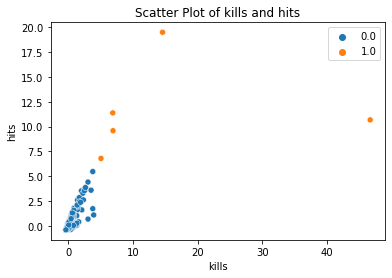

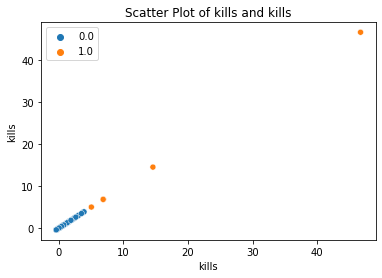

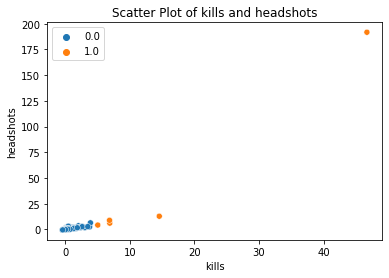

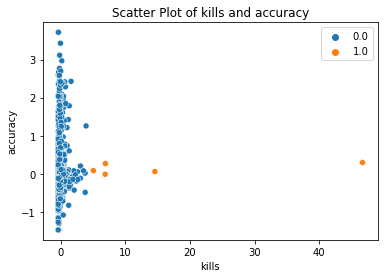

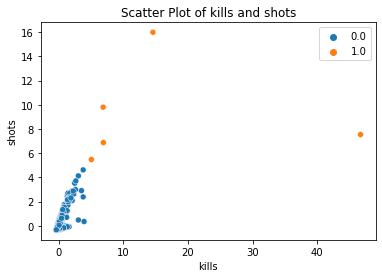

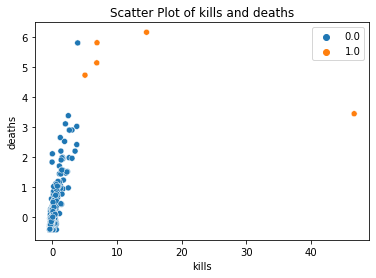

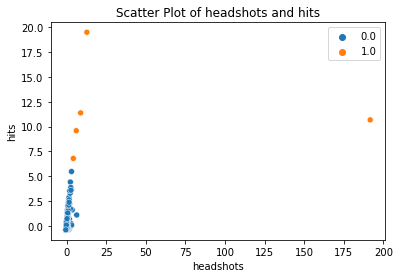

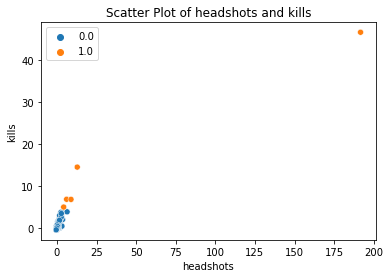

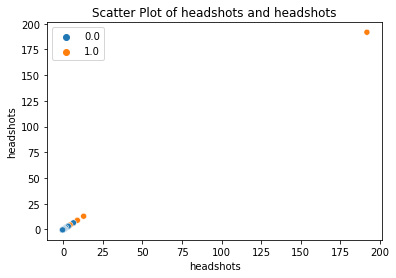

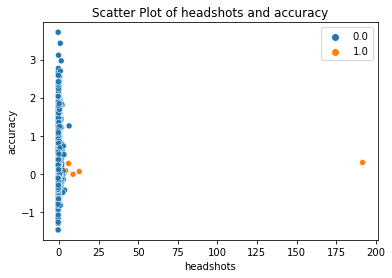

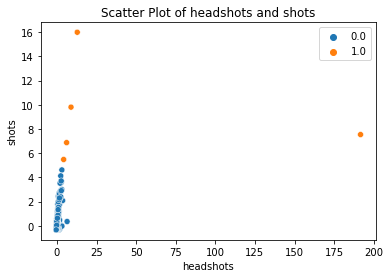

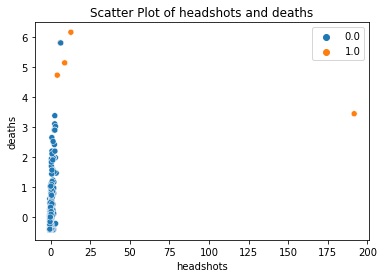

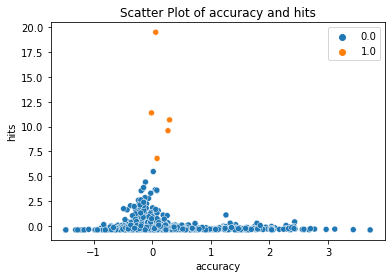

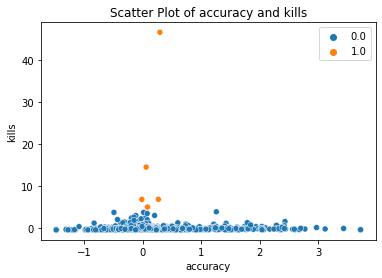

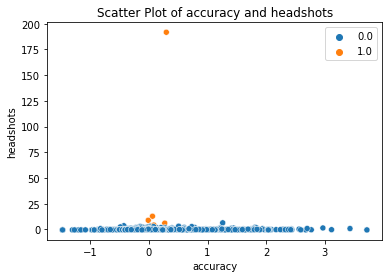

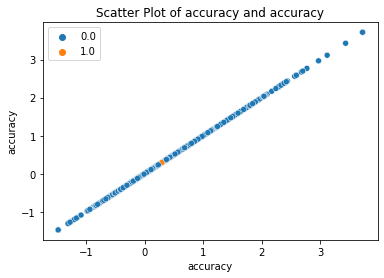

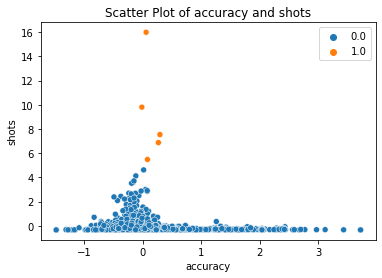

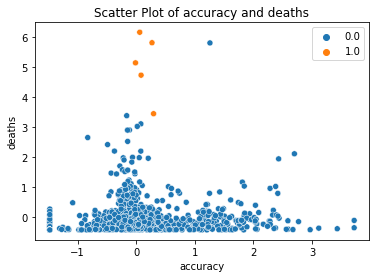

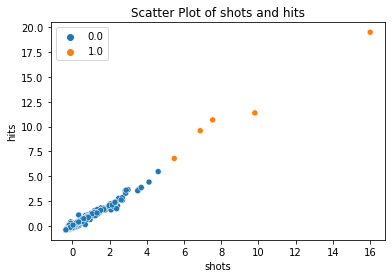

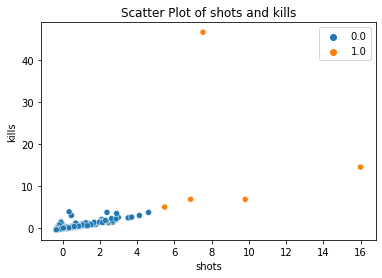

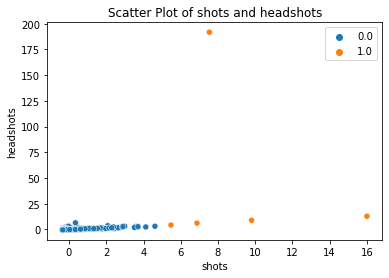

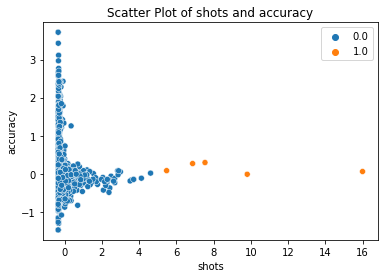

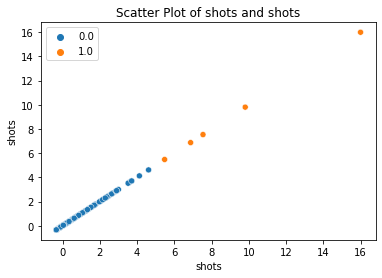

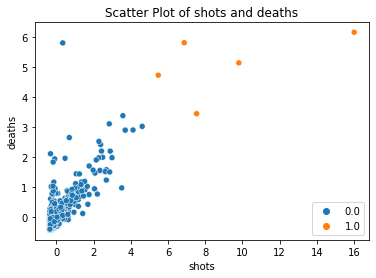

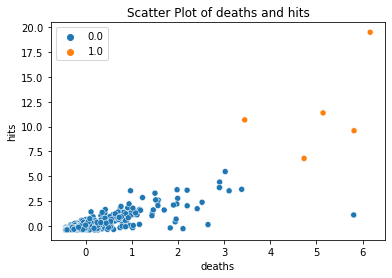

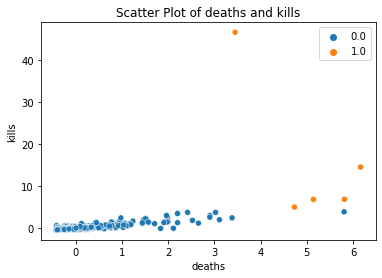

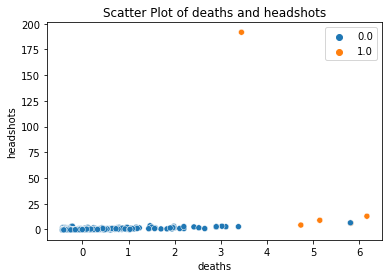

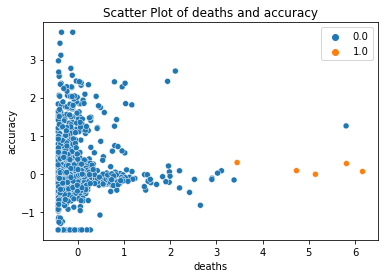

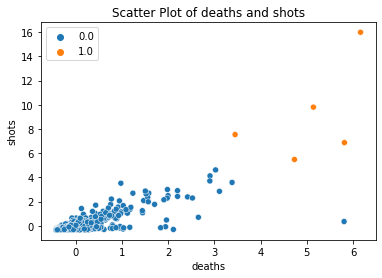

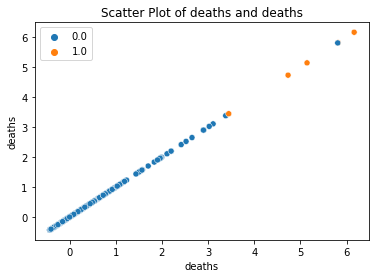

In [100]:
#scatter plot with the kmeans+bagging
for i in range(0,6):
    for j in range(0,6):
        sns.scatterplot(data=x_test,x=x_test.iloc[:,i],y=x_test.iloc[:,j],hue=y_pred_test)
        plt.xlabel(x_test.columns[i])
        plt.ylabel(x_test.columns[j])
        plt.title("Scatter Plot of "+x_test.columns[i]+" and "+x_test.columns[j])
        plt.show()

In [ ]:
#scatter plot with the kmeans+bagging with the true, false, false positive and false negative
for i in range(0,6):
    for j in range(0,6):
        sns.scatterplot(data=x_test,x=x_test.iloc[:,i],y=x_test.iloc[:,j],hue=y_pred_test)
        plt.xlabel(x_test.columns[i])
        plt.ylabel(x_test.columns[j])
        plt.title("Scatter Plot of "+x_test.columns[i]+" and "+x_test.columns[j])
        plt.show()

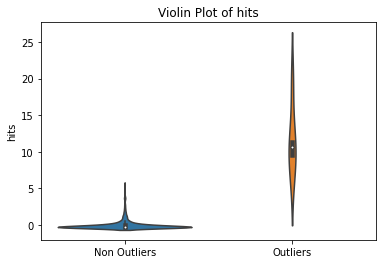

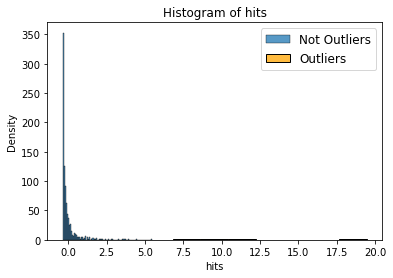

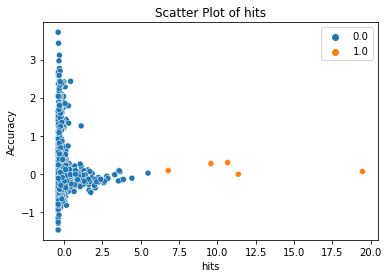

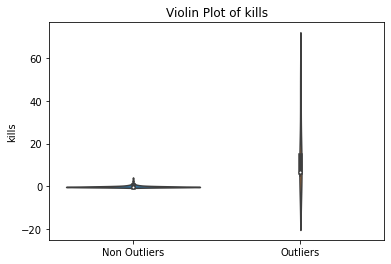

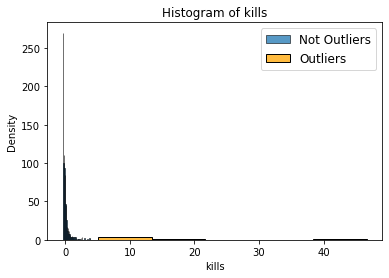

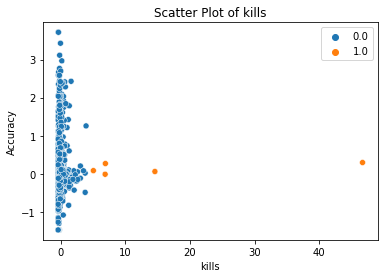

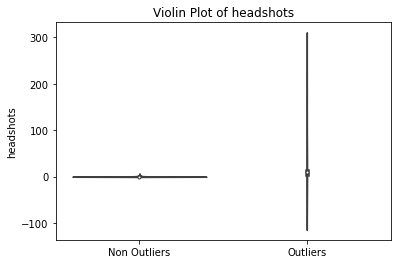

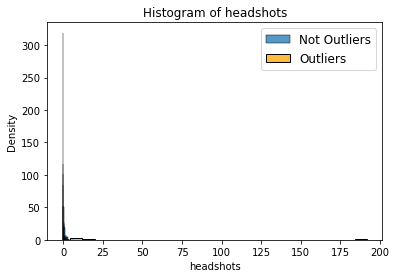

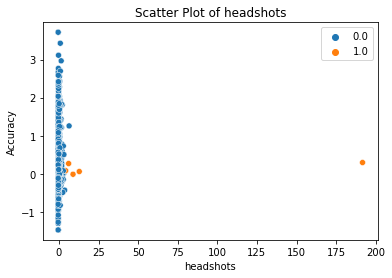

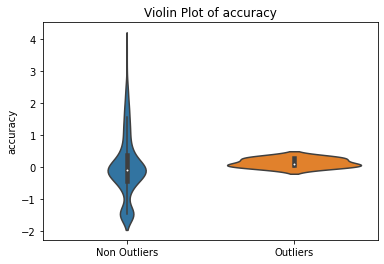

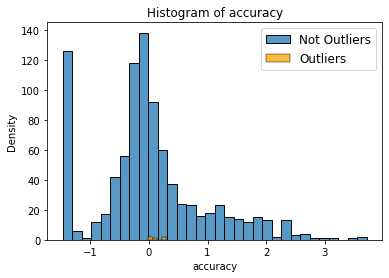

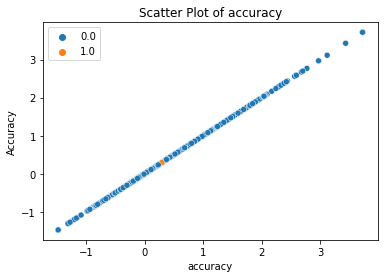

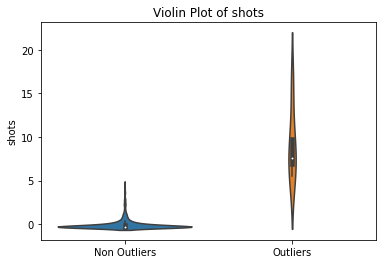

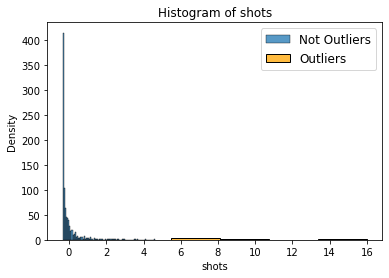

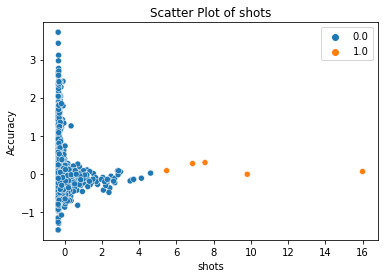

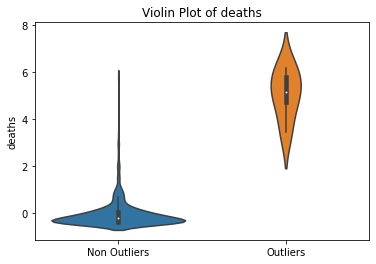

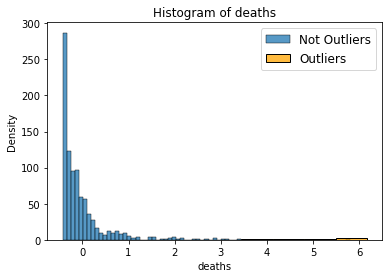

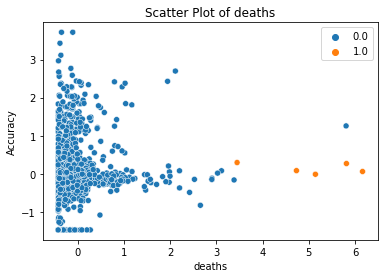

In [103]:
#it appears that the random forest model is the best. It could still be improved.
#Let's explore what the outliers look like with some basic plots.
#vilion plots
for i in range(0,6):
    sns.violinplot(x=y_pred_test,y=x_test.iloc[:,i],data=x_test)
    plt.title('Violin Plot of '+x_test.columns[i])
    plt.xticks(np.arange(2),('Non Outliers','Outliers'))
    plt.show()

#histograms
    df = x_test[y_pred_test==0]
    sns.histplot(df.iloc[:,i],kde=False,label="Not Outliers")
    df = x_test[y_pred_test==1]
    sns.histplot(df.iloc[:,i],kde=False,label="Outliers",color='orange')
    plt.legend(prop={'size': 12})
    plt.title('Histogram of '+x_test.columns[i])
    plt.xlabel(x_test.columns[i])
    plt.ylabel('Density')
    plt.show()

#scatter plot
    sns.scatterplot(data=x_test,x=x_test.iloc[:,i],y='accuracy',hue=y_pred_test)
    plt.xlabel(x_test.columns[i])
    plt.ylabel('Accuracy')
    plt.title("Scatter Plot of "+x_test.columns[i])
    plt.show()